# 1 - Data Preparation

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries

import os, json, random, shutil
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests

## Load Dataset

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/engr5315'
ann_dir = os.path.join(base_dir, 'annotations')
# img_dir = base_dir + '/datasets/coco-reduced/images'
ann_file = os.path.join(ann_dir, 'instances_train2017.json')

with open(ann_file) as file:
  train_ann = json.load(file)

In [ ]:
# filter categories of interest only - 11 categories

category_ids = [annotation['category_id'] for annotation in train_ann['annotations']]
category_counts = Counter(category_ids)

custom_classes = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13]
custom_categories = [c for c in train_ann['categories'] if c['id'] - 1 in custom_classes]
custom_category_ids = [c['id'] for c in custom_categories]

custom_categories

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}]

# 2 - Data Inspection

## Initial Data Distribution

In [ ]:
images_per_class = defaultdict(set)
instances_per_class = defaultdict(int)

for annotation in train_ann['annotations']:
  category_id = annotation['category_id']
  if category_id in custom_category_ids:
    image_id = annotation['image_id']
    images_per_class[category_id].add(image_id)
    instances_per_class[category_id] += 1
images_per_class_count = {category_id: len(image_ids) for category_id, image_ids in images_per_class.items()}


counts_df = pd.DataFrame(list(category_counts.items()), columns=['id','instance_count'])
image_counts_df = pd.DataFrame(list(images_per_class_count.items()), columns=['id','image_count'])
counts_df = pd.merge(counts_df, image_counts_df, left_on='id',right_on='id')
counts_df['instance_pct'] = counts_df['instance_count'] / counts_df['instance_count'].sum() * 100
counts_df['image_pct'] = counts_df['image_count'] / counts_df['image_count'].sum() * 100

categories_df = pd.DataFrame(custom_categories)
categories_df = pd.merge(categories_df, counts_df, left_on='id', right_on='id')
categories_df.reset_index(inplace=True)
categories_df.drop(columns=['index'], inplace=True)

categories_df

,supercategory,id,name,instance_count,image_count,instance_pct,image_pct
0,person,1,person,262465,64115,72.745288,61.017740
1,vehicle,2,bicycle,7113,3252,1.971452,3.094903
2,vehicle,3,car,43867,12251,12.158259,11.659180
3,vehicle,4,motorcycle,8725,3502,2.418237,3.332826
4,vehicle,6,bus,6069,3952,1.682095,3.761087
5,vehicle,7,train,4571,3588,1.266907,3.414671
6,vehicle,8,truck,9973,6127,2.764135,5.831018
7,outdoor,10,traffic light,12884,4139,3.570953,3.939054
8,outdoor,11,fire hydrant,1865,1711,0.516907,1.628345
9,outdoor,13,stop sign,1983,1734,0.549612,1.650234


## Class Imbalance Analysis
- calculate the class distribution
- visualize how many instances belong to each class.

<ipython-input-6-a1cdd0c8bb8d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)
<ipython-input-6-a1cdd0c8bb8d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)


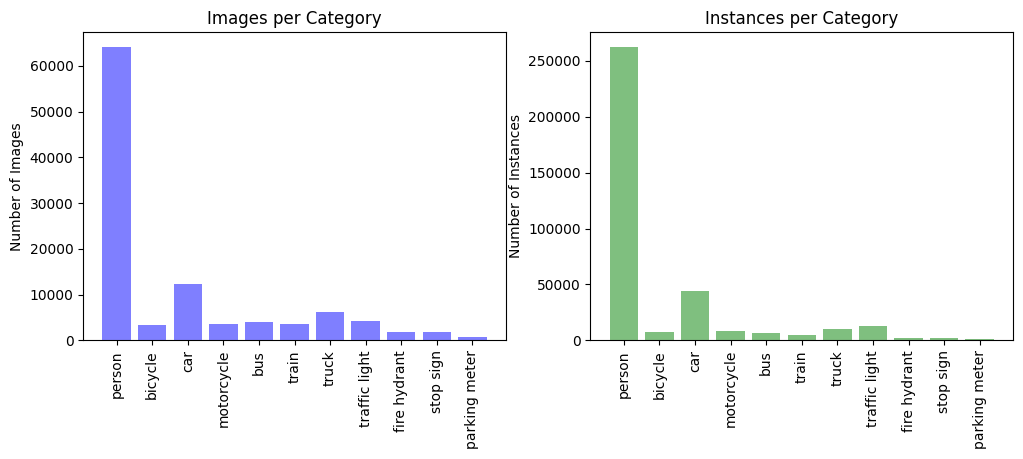

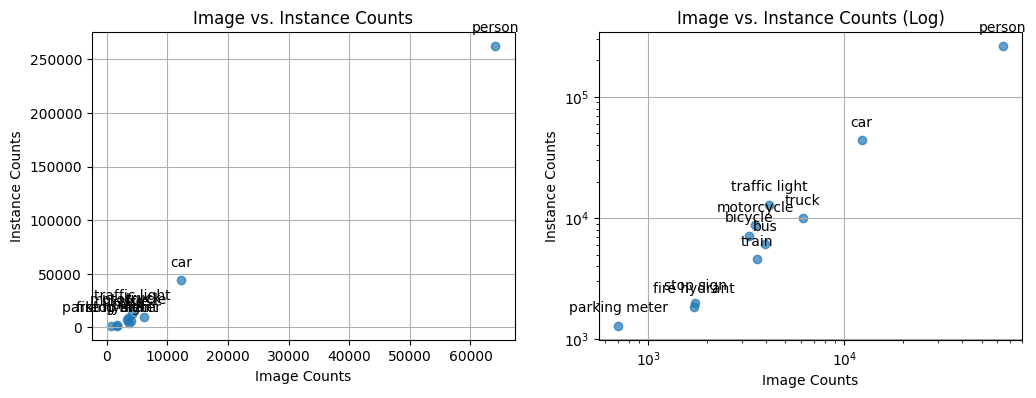

In [ ]:
category_id_to_name = {category['id']: category['name'] for category in custom_categories}

fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].bar(
    [category_id_to_name[cat] for cat in custom_category_ids],
    [images_per_class_count.get(cat, 0) for cat in custom_category_ids],
    color='blue', alpha=0.5)
ax[0].set(ylabel='Number of Images', title='Images per Category')
ax[0].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)

ax[1].bar(
    [category_id_to_name[cat] for cat in custom_category_ids],
    [instances_per_class.get(cat, 0) for cat in custom_category_ids],
    color='green', alpha=0.5)
ax[1].set(ylabel='Number of Instances', title='Instances per Category')
ax[1].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)
plt.show()

# plot number of images vs. number of instances per category
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(
    [images_per_class_count.get(cat, 0) for cat in custom_category_ids],
    [instances_per_class.get(cat, 0) for cat in custom_category_ids],
    alpha=0.7)
for i, cat in enumerate(custom_category_ids):
    ax[0].annotate(category_id_to_name[cat], (images_per_class_count.get(cat, 0), instances_per_class.get(cat, 0)), textcoords="offset points", xytext=(0,10), ha='center')
ax[0].set(xlabel='Image Counts', ylabel='Instance Counts', title='Image vs. Instance Counts')
ax[0].grid(True)

# log scale
ax[1].scatter(
    [images_per_class_count.get(cat, 0) for cat in custom_category_ids],
    [instances_per_class.get(cat, 0) for cat in custom_category_ids],
    alpha=0.7)
for i, cat in enumerate(custom_category_ids):
    ax[1].annotate(category_id_to_name[cat], (images_per_class_count.get(cat, 0), instances_per_class.get(cat, 0)), textcoords="offset points", xytext=(0,10), ha='center')
ax[1].set(xlabel='Image Counts', ylabel='Instance Counts', title='Image vs. Instance Counts (Log)',
          xscale='log', yscale='log')
          # xlim=[0,20000], ylim=[0,50000])
ax[1].grid(True)

plt.show()

# 3 - Data Preprocessing

## Handle Class Imbalance
- apply solutions like undersampling and apply to balance the classes

In [ ]:
# filter annotations for categories of interest only
# for each image
# 1) keep track of which categories are present (as a set)
# 2) count how many times each category shows up in that image

image_categories = {}
image_category_counts = {}

for annotation in train_ann['annotations']:
  image_id = annotation['image_id']
  category_id = annotation['category_id']

  if category_id in custom_category_ids:

    # set of categories
    if image_id not in image_categories:
      image_categories[image_id] = set()
    image_categories[image_id].add(category_id)

    # counts of categories
    if image_id not in image_category_counts:
      image_category_counts[image_id] = {}
    if category_id not in image_category_counts[image_id]:
      image_category_counts[image_id][category_id] = 0
    image_category_counts[image_id][category_id] += 1


In [ ]:
# remove images based on category occurrence thresholds

random.seed(42)


# underrepresented classes that should protect an image from removal
rare_category_ids = {14, 11, 13}  # parking meter, fire hydrant, stop sign

images_to_remove = set()
category_thresholds = {
  1: 3,  # person should be > 3 occurrences to be considered
  3: 3   # Same rule for category 3 (e.g., 'car')
}

# do not remove if any rare categories are present
# remove if image only contains person (class=1)
# if both 'person' (1) and 'car' (3) are present, increase the probability significantly
# then, make final decision based on the calculated probability

def calculate_removal_probability(category_counts, category_thresholds, rare_category_ids):
  base_probability = 0.1

  if any(rare_id in category_counts for rare_id in rare_category_ids):
    return 0

  if list(category_counts.keys()) == [1]:
    return 1

  if 1 in category_counts and 3 in category_counts:
    base_probability *= 10

  for category, threshold in category_thresholds.items():
    if category in category_counts and category_counts[category] >= threshold:
        base_probability = 1  # If a category exceeds its threshold, max out probability

  return min(base_probability, 1)  # ensure probability doesn't exceed 100%



for image_id, category_counts in image_category_counts.items():
  removal_probability = calculate_removal_probability(category_counts, category_thresholds, rare_category_ids)

  if random.random() < removal_probability:
    images_to_remove.add(image_id)

#  create a filtered list of images that don't get removed
filtered_image_category_counts = {}
for image_id, counts in image_category_counts.items():
  if image_id not in images_to_remove:
    filtered_image_category_counts[image_id] = counts

# Output the results
print('Image count before removal:', len(image_category_counts))
print('Number of images to remove:', len(images_to_remove))  # How many images we're removing
print('Image count after filtering:', len(filtered_image_category_counts))  # How many images are left


Image count before removal:  73698
Number of images to remove:  60394
filtered_image_category_counts:  13304


In [ ]:
image_ids = list(image_categories.keys())
filtered_image_ids = [image_id for image_id in image_ids if image_id not in images_to_remove]

sampled_images = {}
sampled_image_ids = []
sampled_image_counts = defaultdict(int)
sampled_instance_counts = defaultdict(int)

for image_id in filtered_image_ids:
  category_counts = filtered_image_category_counts[image_id]
  categories = list(category_counts.keys())

  sampled_image_ids.append(image_id)
  sampled_images[image_id] = set()
  for category in categories:
    sampled_images[image_id].add(category)
    sampled_image_counts[category] += 1
    sampled_instance_counts[category] += category_counts[category]

df1 = pd.DataFrame(list(sampled_image_counts.items()), columns=['id','image_count'])
df2 = pd.DataFrame(list(sampled_instance_counts.items()), columns=['id','instance_count'])
sample_counts_df = pd.merge(df1, df2, left_on='id', right_on='id')
sample_counts_df['image_pct'] = sample_counts_df['image_count'] / sample_counts_df['image_count'].sum() * 100
sample_counts_df['instance_pct'] = sample_counts_df['instance_count'] / sample_counts_df['instance_count'].sum() * 100
sample_counts_df.sort_values(by='id')

categories_df = pd.DataFrame(custom_categories)
categories_df = pd.merge(categories_df, sample_counts_df, left_on='id', right_on='id')
categories_df.reset_index(inplace=True)
categories_df.drop(columns=['index'], inplace=True)
categories_df

,supercategory,id,name,image_count,instance_count,image_pct,instance_pct
0,person,1,person,5568,11654,21.828446,24.797855
1,vehicle,2,bicycle,1349,2396,5.288537,5.098306
2,vehicle,3,car,4787,11348,18.766661,24.146736
3,vehicle,4,motorcycle,1507,2592,5.907950,5.515363
4,vehicle,6,bus,1339,2034,5.249334,4.328028
5,vehicle,7,train,2298,2890,9.008938,6.149460
6,vehicle,8,truck,2784,4224,10.914223,8.987999
7,outdoor,10,traffic light,1726,4725,6.766505,10.054047
8,outdoor,11,fire hydrant,1711,1865,6.707700,3.968423
9,outdoor,13,stop sign,1734,1983,6.797867,4.219508


In [ ]:
# find the most co-occurred pair.

co_occurrences = {}

for image_id, categories in filtered_image_category_counts.items():
  # print(categories)
  if 1 in categories:  # check if category 1 is in the categories for this image
    for category_id in categories:

      if category_id != 1:  # only consider other categories
        if (1, category_id) in co_occurrences:
          co_occurrences[(1, category_id)] += 1
        else:
          co_occurrences[(1, category_id)] = 1

# print(co_occurrences)
print(sorted(co_occurrences.items(), key=lambda item: item[1], reverse=True))


[((1, 3), 2443), ((1, 8), 1300), ((1, 4), 918), ((1, 2), 842), ((1, 6), 693), ((1, 11), 693), ((1, 13), 646), ((1, 7), 627), ((1, 10), 559), ((1, 14), 327)]


In [ ]:
filtered_annotations = [annotation for annotation in train_ann['annotations']
                        if (annotation['image_id'] not in images_to_remove)
                        and (annotation['category_id'] in custom_category_ids)]

print("Initial # of annotations:", len(train_ann['annotations']))
print("Remaining # of annotations:", len(filtered_annotations))

# updat image_categoires with filtered annotatinos
filtered_image_categories = {}

# count occurrences of category_id 1 (persons)
for annotation in filtered_annotations:
    image_id = annotation['image_id']
    category_id = annotation['category_id']

    if image_id not in filtered_image_categories:
        filtered_image_categories[image_id] = set()
    filtered_image_categories[image_id].add(category_id)

# check count again
len(filtered_image_categories)

Initial # of annotations: 860001
Remaining # of annotations: 46996


13304

## Categorical Data Distribution

<ipython-input-14-571cac684b22>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)
<ipython-input-14-571cac684b22>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)


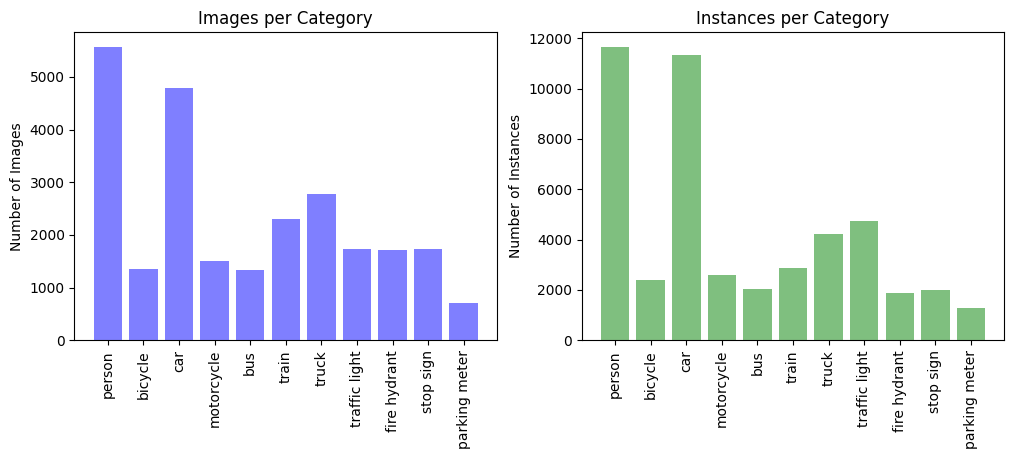

In [ ]:

# category_id_to_name = {category['id']: category['name'] for category in custom_categories}

fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].bar(
    [category_id_to_name[cat] for cat in custom_category_ids],
    categories_df['image_count'],
    color='blue', alpha=0.5)
ax[0].set(ylabel='Number of Images', title='Images per Category')
ax[0].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)

ax[1].bar(
    [category_id_to_name[cat] for cat in custom_category_ids],
    categories_df['instance_count'],
    color='green', alpha=0.5)
ax[1].set(ylabel='Number of Instances', title='Instances per Category')
ax[1].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)
plt.show()


## Object Size Distribution

In [ ]:
# find the max/min size of current dataset

filtered_images = [img for img in train_ann['images'] if img['id'] in filtered_image_ids]

image_size_info = {img['id']: img['width'] * img['height'] for img in filtered_images}
max_key = max(image_size_info, key=image_size_info.get)
min_key = min(image_size_info, key=image_size_info.get)

print(f'max_image_id = {max_key}, max_size = {image_size_info[max_key]}')
sample_img = [img for img in filtered_images if img['id'] == max_key]
print(sample_img)

print(f'min_image_id = {min_key}, min_size = {image_size_info[min_key]}')
sample_img = [img for img in filtered_images if img['id'] == min_key]
print(sample_img)

max_image_id = 268556, max_size = 409600
[{'license': 3, 'file_name': '000000268556.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000268556.jpg', 'height': 640, 'width': 640, 'date_captured': '2013-11-15 14:29:00', 'flickr_url': 'http://farm3.staticflickr.com/2876/9620553260_a812cd5ca1_z.jpg', 'id': 268556}]
min_image_id = 155582, min_size = 19200
[{'license': 2, 'file_name': '000000155582.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000155582.jpg', 'height': 120, 'width': 160, 'date_captured': '2013-11-17 10:18:26', 'flickr_url': 'http://farm1.staticflickr.com/12/18605450_0c4da47971_z.jpg', 'id': 155582}]


0 small salmon [89, 16, 156, 30, 41, 34, 59, 72, 18, 49, 21]
1 medium green [1991, 495, 2064, 368, 287, 423, 640, 873, 417, 367, 210]
2 large navy [9574, 1885, 9128, 2194, 1706, 2433, 3525, 3780, 1430, 1567, 1054]


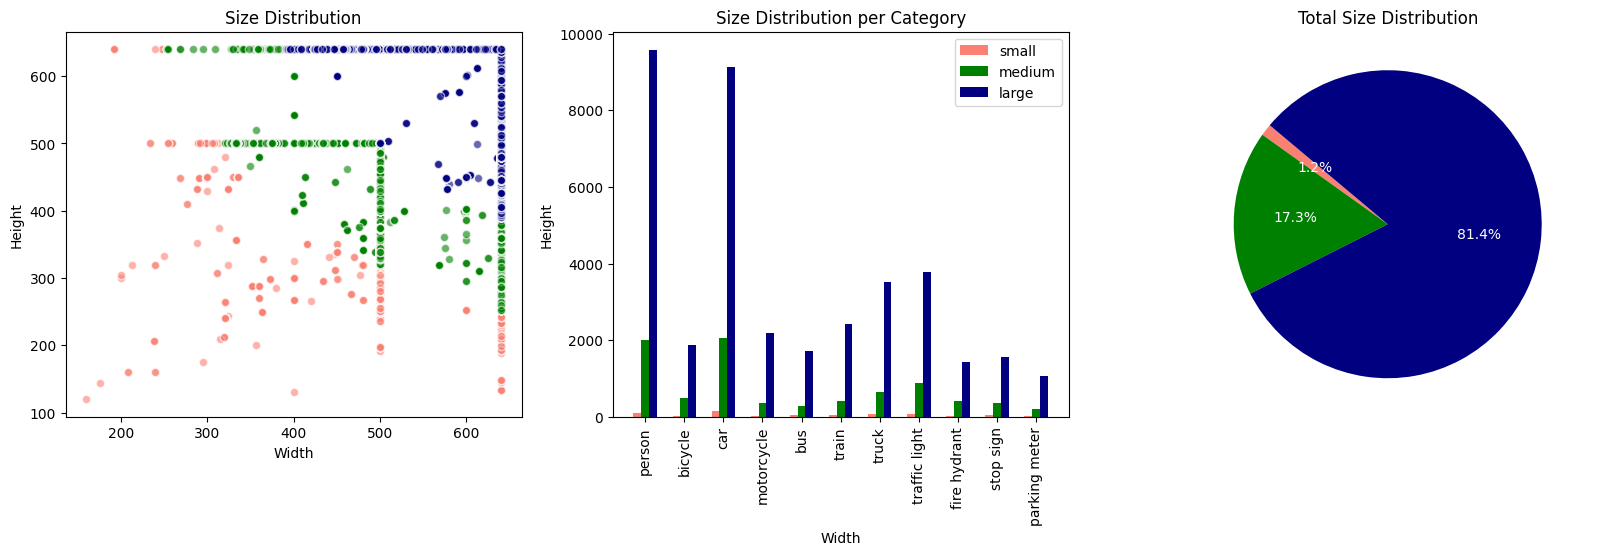

In [ ]:
def categorize_size(width, height):
  area = width * height
  # if area < 320*320:
  if area < 400*400:
      return 'small'
  # elif area < 480*480:
  elif area < 500*500:
      return 'medium'
  else: # 640x640
      return 'large'

size_categories = {'small': [], 'medium': [], 'large': []}
image_info = {img['id']: (img['width'], img['height']) for img in filtered_images}
category_sizes = defaultdict(lambda: {'small': 0, 'medium': 0, 'large': 0})
category_info = defaultdict(list)

for ann in filtered_annotations:
  category_info[ann['category_id']].append(image_info[ann['image_id']])


for category_id, images in category_info.items():
  for width, height in images:
    size_category = categorize_size(width, height)
    size_categories[size_category].append((width, height, category_id))
    category_sizes[category_id][size_category] += 1

# plots
fig,ax = plt.subplots(1,3, figsize=(20,5))
size_colors = {'small': 'salmon', 'medium': 'green', 'large': 'navy'}

for size, points in size_categories.items():
  x = [p[0] for p in points]
  y = [p[1] for p in points]
  ax[0].scatter(x, y, label=size, c=size_colors[size], alpha=0.6, edgecolors='w')

ax[0].set(xlabel='Width', ylabel='Height', title='Size Distribution')

bar_width = 0.2

for i, size_category in enumerate(size_categories.keys()):
  heights = [category_sizes[category][size_category] for category in custom_category_ids]
  print(i, size_category, size_colors[size_category], heights)

  bar_position = [p + bar_width * i for p in range(len(custom_category_ids))]
  ax[1].bar( #[category_id_to_name[cat] for cat in custom_category_ids],
            bar_position,
            heights, width=bar_width, label=size_category, color=size_colors[size_category])

ax[1].set_xticks([p + bar_width for p in range(len(custom_category_ids))])
# ax[1].set_xticklabels(categories)
ax[1].set_xticklabels([category_id_to_name[cat] for cat in custom_category_ids], rotation=90)
ax[1].set(xlabel='Width', ylabel='Height', title='Size Distribution per Category')
ax[1].legend()

total_images_per_size = {size: len(size_categories[size]) for size in size_categories}
ax[2].pie(total_images_per_size.values(),
          labels=total_images_per_size.keys(),
          colors=[size_colors[size] for size in size_categories],
          autopct='%1.1f%%', textprops=dict(color='white'),
          startangle=140)
ax[2].set(title='Total Size Distribution')

plt.show()

## Instance Count Distribution

<ipython-input-17-0edde3897c14>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(category_object_counts))


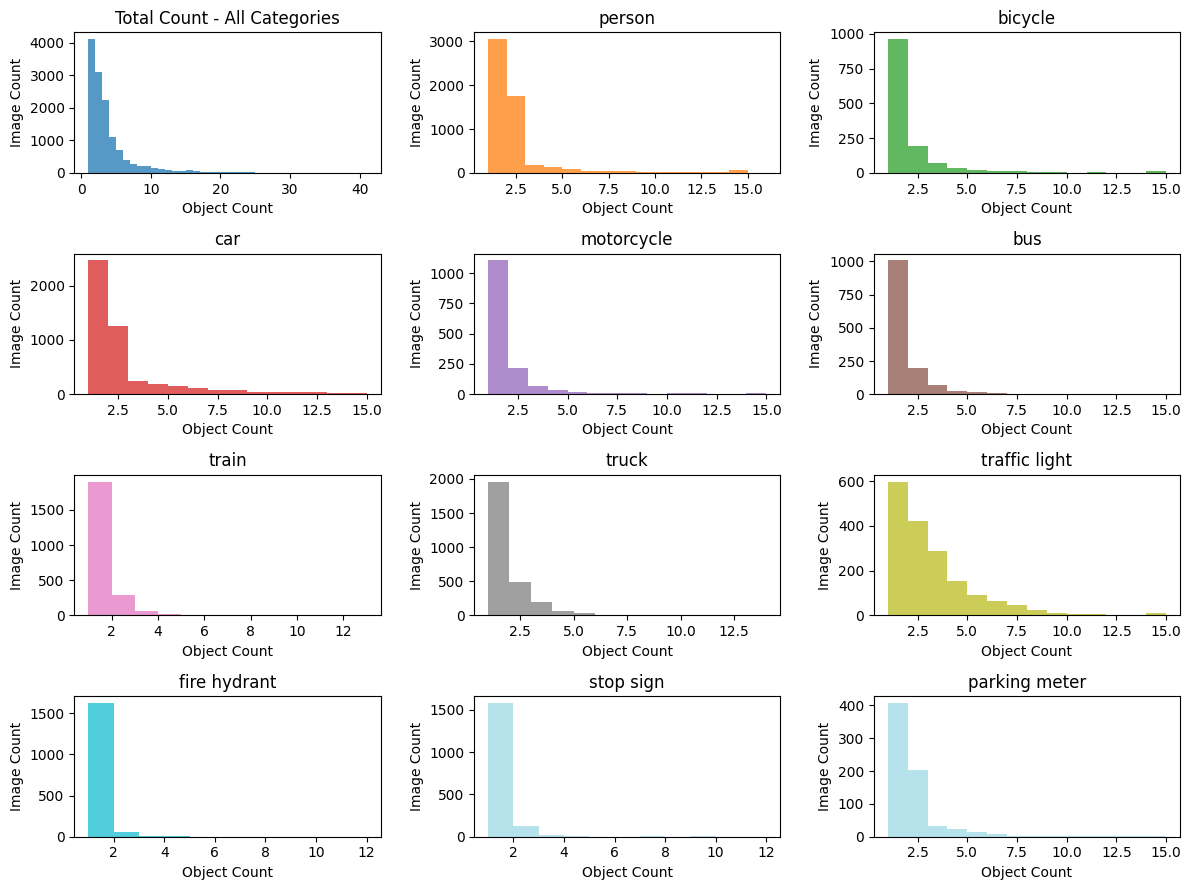

In [ ]:
filtered_image_category_counts = {}

# Count occurrences of category_id 1 (persons)
for annotation in filtered_annotations:
  image_id = annotation['image_id']
  category_id = annotation['category_id']

  # counts of categories
  if image_id not in filtered_image_category_counts:
    filtered_image_category_counts[image_id] = {}
  if category_id not in filtered_image_category_counts[image_id]:
    filtered_image_category_counts[image_id][category_id] = 0
  filtered_image_category_counts[image_id][category_id] += 1

category_object_counts = defaultdict(list)
total_objects_per_image  = defaultdict(int)

for image_id, category_counts in filtered_image_category_counts.items():
  for category_id, count in category_counts.items():
    category_object_counts[category_id].append(count)
  for count in category_counts.values():
    total_objects_per_image [image_id] += count

fig,ax = plt.subplots(4,3, figsize=(12,9))
ax = ax.flatten()

# histogram for each category
color_map = plt.cm.get_cmap('tab20', len(category_object_counts))
total_objects_counts = list(total_objects_per_image.values())
# total_objects_counts = [sum(counts.values()) for counts in filtered_image_category_counts.values()]
ax[0].hist(total_objects_counts, bins=range(1, max(total_objects_counts)+2), alpha=0.75, color=color_map(0))
ax[0].set(xlabel='Object Count', ylabel='Image Count', title='Total Count - All Categories')

category_object_counts = sorted(category_object_counts.items())
for i, (category_id, counts) in enumerate(category_object_counts):
  ax[i+1].hist(counts, bins=range(1, max(counts)+2), alpha=0.75, color=color_map(i+1))
  ax[i+1].set(xlabel='Object Count', ylabel='Image Count', title=category_id_to_name[category_id])


fig.tight_layout()
# plt.show()

# 4 - Dataset Conversion

## Create YOLO Dataset
- convert coco annotations to yolo format
- dataset split: train-val-test (80%, 10%, 10%)

In [ ]:
def create_yolo_labels(annotations, image_id_to_filename, image_dimensions, output_dir):
  for ann in annotations:
    category_id = ann['category_id']
    image_id = ann['image_id']

    bbox = ann['bbox']
    x, y, w, h = bbox # coco format

    # convert to yolo format
    x_center = x + w / 2
    y_center = y + h / 2
    image_width, image_height = image_dimensions[image_id]
    x_center /= image_width
    y_center /= image_height
    w /= image_width
    h /= image_height

    filename = image_id_to_filename[image_id].replace('.jpg','.txt')
    filename = os.path.join(output_dir, filename)
    # print(filename)

    with open(filename, 'a') as f:
      f.write(f'{category_id} {x_center} {y_center} {w} {h}\n')
      # print(f'{category_id} {x_center} {y_center} {w} {h}\n')

In [ ]:
# annotation category: yolo label in yaml
annotation_yolo_mapping = {
    1: 0,   # person
    2: 1,   # bicycle
    3: 2,   # car
    4: 3,   # motorcycle
    6: 4,   # bus
    7: 5,   # train
    8: 6,   # truck
    10: 7,  # traffic light
    11: 8,  # fire hydrant
    13: 9,  # stop sign
    14: 10  # parking meter
}

# remove categorys not in our list
updated_train_ann = [ann for ann in train_ann['annotations'] if ann['category_id'] in custom_category_ids]

# update the annotations with the mapping aboe
for annotation in updated_train_ann:
  original_id = annotation['category_id']
  if original_id in annotation_yolo_mapping:
    annotation['category_id'] = annotation_yolo_mapping[original_id]
  else:
    raise ValueError(f'Original ID {original_id} not found in mapping.')

# update categories with above mapping
# updated_custom_categories = [ann for ann in custom_categories]
for category in custom_categories:
  original_id = category['id']
  if original_id in annotation_yolo_mapping:
    category['id'] = annotation_yolo_mapping[original_id]
  else:
    raise ValueError(f'Original ID {original_id} not found in mapping.')

custom_categories

[{'supercategory': 'person', 'id': 0, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 1, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'truck'},
 {'supercategory': 'outdoor', 'id': 7, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 8, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 9, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'parking meter'}]

In [ ]:
# filtered_images = [img for img in train_ann['images'] if img['id'] in image_ids]
train_split_index = int(len(filtered_image_ids) *  0.8)
val_split_index = int(len(filtered_image_ids) *  0.9)
print('train_split_index: ', train_split_index)
print('val_split_index: ', val_split_index)
print('--')

train_image_ids = filtered_image_ids[:train_split_index]
val_image_ids = filtered_image_ids[train_split_index:val_split_index]
test_image_ids = filtered_image_ids[val_split_index:]
print('train_image_ids: ', len(train_image_ids))
print('val_image_ids: ', len(val_image_ids))
print('test_image_ids: ', len(test_image_ids))
print('--')

filtered_train_images = [img for img in train_ann['images'] if img['id'] in train_image_ids]
filtered_val_images = [img for img in train_ann['images'] if img['id'] in val_image_ids]
filtered_test_images = [img for img in train_ann['images'] if img['id'] in test_image_ids]

# filtered_train_annotations = [ann for ann in train_ann['annotations'] if ann['image_id'] in train_image_ids and ann['category_id'] in custom_category_ids]
# filtered_val_annotations = [ann for ann in train_ann['annotations'] if ann['image_id'] in val_image_ids and ann['category_id'] in custom_category_ids]
# filtered_test_annotations = [ann for ann in train_ann['annotations'] if ann['image_id'] in test_image_ids and ann['category_id'] in custom_category_ids]
filtered_train_annotations = [ann for ann in updated_train_ann if ann['image_id'] in train_image_ids]
filtered_val_annotations = [ann for ann in updated_train_ann if ann['image_id'] in val_image_ids]
filtered_test_annotations = [ann for ann in updated_train_ann if ann['image_id'] in test_image_ids]

print('filtered_train_images: ', len(filtered_train_images))
print('filtered_val_images: ', len(filtered_val_images))
print('filtered_test_images: ', len(filtered_test_images))
print('--')

print('filtered_train_annotations: ', len(filtered_train_annotations))
print('filtered_val_annotations: ', len(filtered_val_annotations))
print('filtered_test_annotations: ', len(filtered_test_annotations))

train_split_index:  10643
val_split_index:  11973
--
train_image_ids:  10643
val_image_ids:  1330
test_image_ids:  1331
--
filtered_train_images:  10643
filtered_val_images:  1330
filtered_test_images:  1331
--
filtered_train_annotations:  39650
filtered_val_annotations:  3770
filtered_test_annotations:  3576


In [ ]:
train_ann_split = {
    'images': filtered_train_images,
    'annotations': filtered_train_annotations,
    'categories': custom_categories
}

val_ann_split = {
    'images': filtered_val_images,
    'annotations': filtered_val_annotations,
    'categories': custom_categories
}

test_ann_split = {
    'images': filtered_test_images,
    'annotations': filtered_test_annotations,
    'categories': custom_categories
}

train_ann_file = ann_dir + '/instances_train_custom.json'
val_ann_file = ann_dir + '/instances_val_custom.json'
test_ann_file = ann_dir + '/instances_test_custom.json'


with open(train_ann_file, 'w') as file:
    json.dump(train_ann_split, file)

with open(val_ann_file, 'w')as file:
    json.dump(val_ann_split, file)

with open(test_ann_file, 'w')as file:
    json.dump(test_ann_split, file)

In [ ]:
image_id_to_filename = {img['id']: img['file_name'] for img in train_ann['images']}
image_id_to_url = {img['id']: img['coco_url'] for img in train_ann['images']}
image_dimensions = {img['id']: (img['width'], img['height']) for img in train_ann['images']}

In [ ]:
# uncomment to re-run label creation
# shutil.rmtree(base_dir / 'datasets/coco-reduced2/labels')

labels_dir = base_dir + '/datasets/labels'
output_train_labels_dir = labels_dir + '/train'
output_val_labels_dir = labels_dir + '/val'
output_test_labels_dir = labels_dir + '/test'

os.makedirs(output_train_labels_dir, exist_ok=True)
os.makedirs(output_val_labels_dir, exist_ok=True)
os.makedirs(output_test_labels_dir, exist_ok=True)

create_yolo_labels(filtered_train_annotations, image_id_to_filename, image_dimensions, output_train_labels_dir)
create_yolo_labels(filtered_val_annotations, image_id_to_filename, image_dimensions, output_val_labels_dir)
create_yolo_labels(filtered_test_annotations, image_id_to_filename, image_dimensions, output_test_labels_dir)

In [ ]:
print('Number of total images: ', len(image_ids))
print('Number of total annotations: ', len(filtered_annotations))

Number of total images:  73698
Number of total annotations:  46996


In [ ]:
# download images from coco url in annotations

img_dir = base_dir + '/datasets/images'
os.makedirs(img_dir + '/train', exist_ok=True)
os.makedirs(img_dir + '/val', exist_ok=True)
os.makedirs(img_dir + '/test', exist_ok=True)

def download_image(url, dst_path):
  response = requests.get(url, stream=True)
  if response.status_code == 200:
    with open(dst_path, 'wb') as f:
      f.write(response.content)
  else:
      print(f"Failed to download {url}")

# download image files
for image_id in train_image_ids:
    filename = image_id_to_filename[image_id]
    image_url = image_id_to_url[image_id]
    dst_path = img_dir + '/train/' + filename
    download_image(image_url, dst_path)

for image_id in val_image_ids:
    filename = image_id_to_filename[image_id]
    image_url = image_id_to_url[image_id]
    dst_path = img_dir + '/val/' + filename
    download_image(image_url, dst_path)

for image_id in test_image_ids:
    filename = image_id_to_filename[image_id]
    image_url = image_id_to_url[image_id]
    dst_path = img_dir + '/test/' + filename
    download_image(image_url, dst_path)


In [ ]:
print('train images: ', len(os.listdir(img_dir + '/train')))
print('val images: ', len(os.listdir(img_dir + '/val')))
print('test images: ', len(os.listdir(img_dir + '/test')))

train images:  10643
val images:  1330
test images:  1331


## Display Sample Images

In [ ]:
# [ann for ann in filtered_annotations if ann['image_id'] == 135820]
# [ann['category_id'] for ann in filtered_annotations if ann['image_id'] == 539259]
filtered_images
[img for img in filtered_images if img['id'] == 135820]

[]

In [ ]:
# redo the mapping

category_id_to_name

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 6: 'bus',
 7: 'train',
 8: 'truck',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter'}

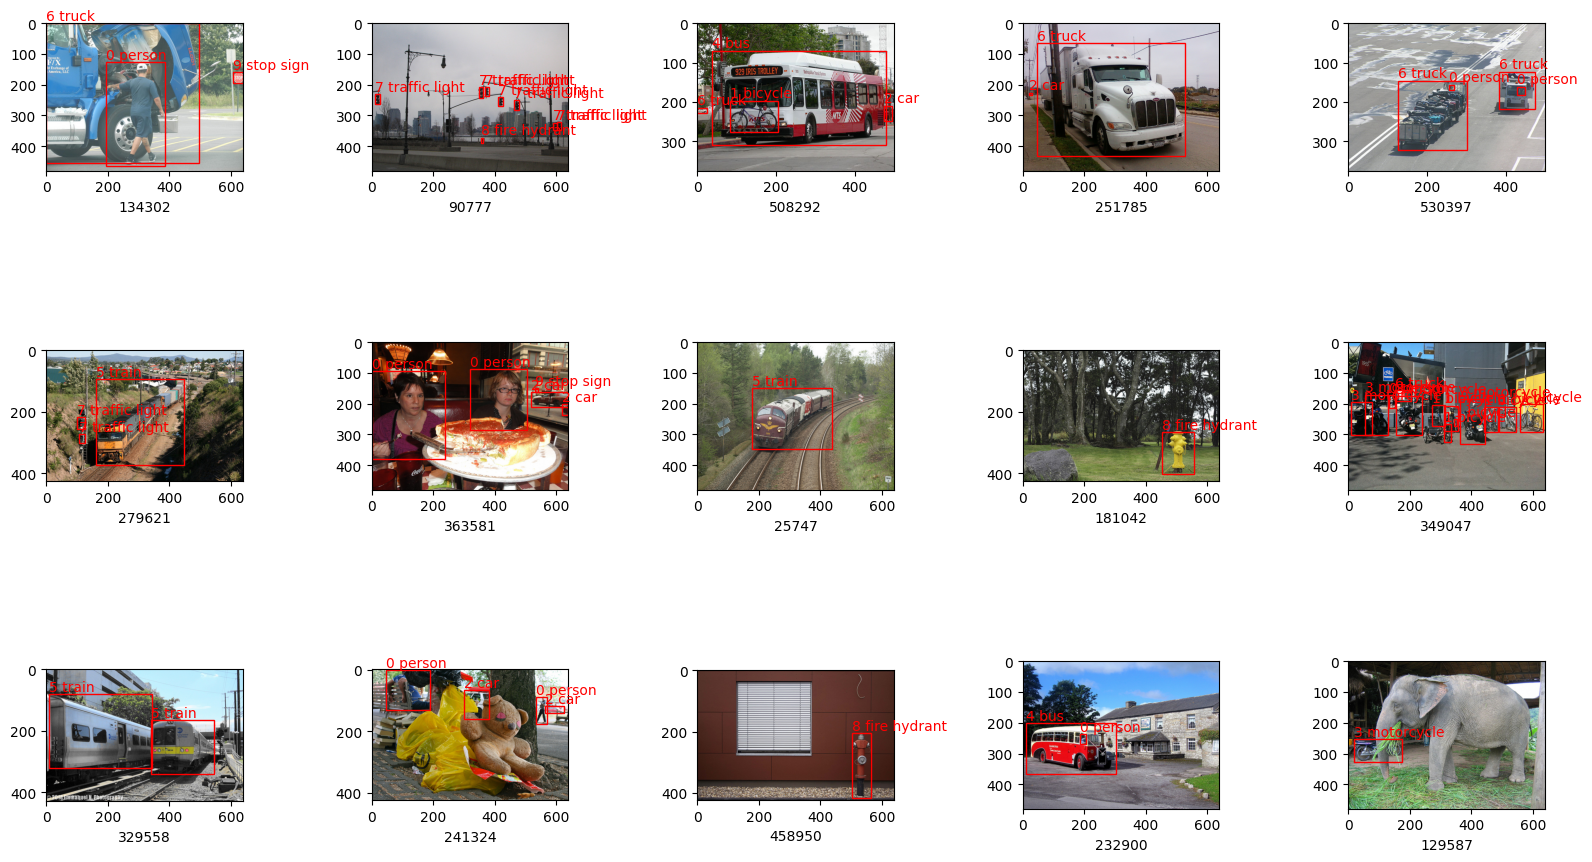

In [ ]:
import cv2

category_id_to_name = {category['id']: category['name'] for category in custom_categories}
train_img_dir = img_dir + '/train'
display_images = os.listdir(train_img_dir)
random.seed(1)
random.shuffle(display_images)

fig, ax = plt.subplots(3,5, figsize=(16,10))
ax = ax.flatten()

for i, filename in enumerate(display_images[:15]):
  image_id = [id for id, value in image_id_to_filename.items() if value == filename][0]
  # print(i, filename)
  image_path = os.path.join(train_img_dir, filename)
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  ax[i].imshow(image_rgb)
  # ax[i].axis('off')
  ax[i].set(xlabel=image_id)

  # draw bounding boxes and add category labels
  for ann in filtered_annotations:
    if ann['image_id'] == image_id:
      bbox = ann['bbox']
      category_id = ann['category_id']
      category_label = str(category_id) + ' ' + category_id_to_name[category_id]
      x, y, w, h = bbox
      rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none')
      ax[i].add_patch(rect)
      ax[i].text(x, y - 10, category_label, color='red', fontsize=10)

plt.tight_layout()
plt.show()


## Include 5% Null Images

In [ ]:
annotated_image_ids = set()

for annotation in train_ann['annotations']:
  annotated_image_ids.add(annotation['image_id'])

unannotated_image_ids = set(image_id_to_filename.keys()) - annotated_image_ids
unannotated_images = [image_id_to_filename[image_id] for image_id in unannotated_image_ids]

print(f'Total unannotated images: {len(unannotated_images)}')

Total unannotated images: 1021


In [ ]:
# download images
null_img_dir = img_dir + '/null'
os.makedirs(null_img_dir, exist_ok=True)

for image_id in unannotated_image_ids:
  filename = image_id_to_filename[image_id]
  image_url = image_id_to_url[image_id]
  dst_path = img_dir + '/null/' + filename
  download_image(image_url, dst_path)

# count check
len(os.listdir(null_img_dir))

1021

In [ ]:
keep_ratio = 0.05
keep_count = int(len(filtered_images) * keep_ratio)
print(keep_count)

random.seed(42)
unannotated_image_ids = list(unannotated_image_ids)  # Convert set to list
random.shuffle(unannotated_image_ids)
unannotated_image_ids = unannotated_image_ids[:keep_count]

train_split_index = int(len(train_image_ids) * keep_ratio)
val_split_index = train_split_index + int(len(val_image_ids) * keep_ratio)

null_train_image_ids = unannotated_image_ids[:train_split_index]
null_val_image_ids = unannotated_image_ids[train_split_index:val_split_index]
null_test_image_ids = unannotated_image_ids[val_split_index:]


In [ ]:
# move null images to custom dataset

for image_id in null_train_image_ids:
    filename = image_id_to_filename[image_id]
    src_path = os.path.join(null_img_dir, filename)
    dst_path = img_dir + '/train/' + filename
    shutil.copy(src_path, dst_path)

for image_id in null_val_image_ids:
    filename = image_id_to_filename[image_id]
    src_path = os.path.join(null_img_dir, filename)
    dst_path = img_dir + '/val/' + filename
    shutil.copy(src_path, dst_path)

for image_id in null_test_image_ids:
    filename = image_id_to_filename[image_id]
    src_path = os.path.join(null_img_dir, filename)
    dst_path = img_dir + '/test/' + filename
    shutil.copy(src_path, dst_path)


In [ ]:
print('train images: ', len(os.listdir(img_dir + '/train')))
print('val images: ', len(os.listdir(img_dir + '/val')))
print('train test: ', len(os.listdir(img_dir + '/test')))

train images:  11173
val images:  1397
train test:  1398
